In [1]:
import pandas as pd
from collections import defaultdict
import warnings
import visualize
import neat
import multiprocessing
import os
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

from random import randint


X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[:1617]
y = digits.target[:1617]

def softmax(x, axis=1):
    # 计算每行的最大值
    row_max = x.max(axis=axis)
 
    # 每行元素都需要减去对应的最大值，否则求exp(x)会溢出，导致inf情况
    row_max=row_max.reshape(-1, 1)
    x = x - row_max
 
    # 计算e的指数次幂
    x_exp = np.exp(x)
    x_sum = np.sum(x_exp, axis=axis, keepdims=True)
    s = x_exp / x_sum
    return s

def get_winner(class1):
    
    numbers = [*range(10)] # number 2 > number 1
    number_of_classification = len(numbers)
    #number_of_sampling = 100

    list_y = y.tolist()
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

        
    class2 = []

    class1_indexes = []
    class2_indexes = []

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)

    print("number of class1:{}".format(len(class1_label)))
    print("number of class2:{}".format(len(class2_label)))

    samplesize = 1617
    x_inputs =[tuple(c) for c in X[class1_indexes].tolist()] + [tuple(c) for c in X[class2_indexes].tolist()]
    x_outputs = [tuple([c]) for c in class1_label + class2_label]
    
    
    def eval_genomes(genomes, config):
        for genome_id, genome in genomes:
            net = neat.nn.FeedForwardNetwork.create(genome, config)

            outputs = []
            for xi in x_inputs:
                output = net.activate(xi)
                outputs.append(output)


            px_outputs = softmax(np.array(outputs).reshape(samplesize, 2), axis=1)
            # the index of maximum in each line
            pred_outputs = np.argmax(px_outputs, axis = 1)
            real_outputs = np.array(x_outputs).reshape(samplesize,)

            acc = np.sum(pred_outputs == real_outputs)/samplesize

            genome.fitness = acc

    def run(config_file):
        # Load configuration.
        config = neat.Config(
            neat.DefaultGenome,
            neat.DefaultReproduction,
            neat.DefaultSpeciesSet,
            neat.DefaultStagnation,
            config_file,
        )

        # Create the population, which is the top-level object for a NEAT run.
        p = neat.Population(config)

        # add a stdout reporter to show progress in the terminal
        reporter = neat.StdOutReporter(False)
        p.add_reporter(reporter)
        stats = neat.StatisticsReporter()
        p.add_reporter(stats)
        #checkpointer = neat.Checkpointer(100)
        #p.add_reporter(checkpointer)
        # Run for up to 300 generations.
        winner = p.run(eval_genomes, 3)

        return [stats, winner]
    
    local_dir = os.getcwd()
    config_path = os.path.join(local_dir, "config-feedforward-mnist2")
    [stats, winner] = run(config_path)
    
    return winner

def get_pred_real(i, j):
    winner_net = neat.nn.FeedForwardNetwork.create(winner_list[i], config)
    
    numbers = [*range(10)]
    class1 = classes[i]
    class2 = []
    class1_indexes = []
    class2_indexes = []
    
    test_X = digits.images.reshape(digits.images.shape[0], digits.images.shape[1] * digits.images.shape[2])[j]
    test_y = digits.target[j]

    list_y = [test_y]
    digits_indexes = []
    for digit in numbers:
        li = [i for i in range(len(list_y)) if list_y[i] == digit]
        digits_indexes.extend([li])

    for i in numbers:
        if i in class1:
            class1_indexes.extend(digits_indexes[i])
        else:
            class2_indexes.extend(digits_indexes[i])
            class2.append(i)

    class1_label = [1] * len(class1_indexes)
    class2_label = [0] * len(class2_indexes)


    testsamplesize = 1
    test_x_inputs =[tuple(test_X)]
    test_x_outputs = [tuple([c]) for c in class1_label + class2_label]

    outputs = []
    for xi in test_x_inputs:
        output = winner_net.activate(xi)
        outputs.append(output)

    px_outputs = softmax(np.array(outputs).reshape(testsamplesize, 2), axis=1)
    # the index of maximum in each line
    pred_outputs = np.argmax(px_outputs, axis = 1)
    real_outputs = np.array(test_x_outputs).reshape(testsamplesize,)

    
    return [pred_outputs, real_outputs]

acc_list = []

number_codes = []
for i in range(2**(10-1), 2**10-1):
    for j in bin(i).split('b')[1]:
        number_codes.append(int(j))
number_codes = np.array(number_codes).reshape(2**9 - 1,10).T.tolist()
classes = []
for i in range(2**(10-1) - 1):
    code_list = np.array(number_codes).T[i]
    classes.append(np.where(code_list==1)[0].tolist())

winner_list = []

for class1 in classes:
    winner = get_winner(class1)
    winner_list.append(winner)

local_dir = os.getcwd()
config_path = os.path.join(local_dir, "config-feedforward-mnist2")

config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path,
)

pred_value = []
error_list = []

for j in range(1617,1617+180):
    pred = []
    for i in range(511):
        [pred_outputs, real_outputs] = get_pred_real(i, j)
        #print(pred_outputs, real_outputs)
        pred.append(pred_outputs)
    #print(np.array(pred).T)

    error = []
    for i in range(10):
        error.append(511 - np.sum(number_codes[i] == np.array(pred).T))
    #print(error)

    pred_value.append(np.where(error==np.min(error)))
    error_list.append(np.min(error))
    #print(np.where(error==np.min(error)) )

list_P = []
for i in pred_value:
    if (len(i[0])) == 1:
        list_P.append(i[0][0])
    else:
        random_pick = randint(0, len(i[0])-1)
        list_P.append(i[0][random_pick])

acc = np.sum(list_P == digits.target[1617:])/180
print(acc)


number of class1:162
number of class2:1455

 ****** Running generation 0 ****** 

Population's average fitness: 0.58556 stdev: 0.27059
Best fitness: 0.91156 - size: (2, 13) - species 5 - id 95
Average adjusted fitness: 0.493
Mean genetic distance 2.914, standard deviation 0.496
Population of 200 members in 26 species
Total extinctions: 0
Generation time: 5.498 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.72446 stdev: 0.23375
Best fitness: 0.95300 - size: (2, 14) - species 21 - id 360
Average adjusted fitness: 0.603
Mean genetic distance 2.977, standard deviation 0.506
Population of 202 members in 26 species
Total extinctions: 0
Generation time: 5.521 sec (5.509 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.78744 stdev: 0.20229
Best fitness: 0.95300 - size: (2, 14) - species 2 - id 360
Average adjusted fitness: 0.655
Mean genetic distance 2.996, standard deviation 0.510
Population of 202 members in 27 species
Total extincti

number of class2:1292

 ****** Running generation 0 ****** 

Population's average fitness: 0.53891 stdev: 0.21840
Best fitness: 0.88992 - size: (2, 13) - species 1 - id 7
Average adjusted fitness: 0.447
Mean genetic distance 2.895, standard deviation 0.490
Population of 201 members in 23 species
Total extinctions: 0
Generation time: 4.973 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.68442 stdev: 0.17598
Best fitness: 0.89054 - size: (3, 15) - species 7 - id 356
Average adjusted fitness: 0.448
Mean genetic distance 3.007, standard deviation 0.479
Population of 202 members in 28 species
Total extinctions: 0
Generation time: 5.400 sec (5.187 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.68335 stdev: 0.18935
Best fitness: 0.89054 - size: (3, 15) - species 5 - id 356
Average adjusted fitness: 0.500
Mean genetic distance 3.024, standard deviation 0.473
Population of 206 members in 30 species
Total extinctions: 0
Generation time:


 ****** Running generation 0 ****** 

Population's average fitness: 0.57024 stdev: 0.21009
Best fitness: 0.82127 - size: (2, 13) - species 2 - id 66
Average adjusted fitness: 0.398
Mean genetic distance 2.931, standard deviation 0.473
Population of 199 members in 27 species
Total extinctions: 0
Generation time: 5.131 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.68835 stdev: 0.16739
Best fitness: 0.86333 - size: (3, 15) - species 25 - id 372
Average adjusted fitness: 0.494
Mean genetic distance 3.020, standard deviation 0.496
Population of 202 members in 30 species
Total extinctions: 0
Generation time: 5.476 sec (5.303 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70359 stdev: 0.16604
Best fitness: 0.88621 - size: (4, 17) - species 11 - id 512
Average adjusted fitness: 0.490
Mean genetic distance 3.025, standard deviation 0.497
Population of 200 members in 33 species
Total extinctions: 0
Generation time: 5.692 sec (5.433 a

number of class1:489
number of class2:1128

 ****** Running generation 0 ****** 

Population's average fitness: 0.56072 stdev: 0.14533
Best fitness: 0.80025 - size: (2, 13) - species 4 - id 7
Average adjusted fitness: 0.320
Mean genetic distance 2.889, standard deviation 0.478
Population of 201 members in 18 species
Total extinctions: 0
Generation time: 6.771 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61870 stdev: 0.14311
Best fitness: 0.82684 - size: (3, 14) - species 2 - id 330
Average adjusted fitness: 0.378
Mean genetic distance 2.873, standard deviation 0.472
Population of 200 members in 21 species
Total extinctions: 0
Generation time: 5.748 sec (6.260 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.62451 stdev: 0.15271
Best fitness: 0.84168 - size: (3, 15) - species 4 - id 519
Average adjusted fitness: 0.450
Mean genetic distance 2.889, standard deviation 0.484
Population of 201 members in 23 species
Total extinction

number of class2:1294

 ****** Running generation 0 ****** 

Population's average fitness: 0.55167 stdev: 0.21208
Best fitness: 0.82870 - size: (2, 13) - species 5 - id 189
Average adjusted fitness: 0.365
Mean genetic distance 2.836, standard deviation 0.461
Population of 198 members in 22 species
Total extinctions: 0
Generation time: 5.197 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.65432 stdev: 0.19859
Best fitness: 0.90971 - size: (3, 15) - species 3 - id 293
Average adjusted fitness: 0.480
Mean genetic distance 2.939, standard deviation 0.493
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 5.565 sec (5.381 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70405 stdev: 0.16918
Best fitness: 0.90971 - size: (3, 15) - species 3 - id 293
Average adjusted fitness: 0.540
Mean genetic distance 2.922, standard deviation 0.494
Population of 201 members in 26 species
Total extinctions: 0
Generation tim

Mean genetic distance 2.995, standard deviation 0.493
Population of 200 members in 32 species
Total extinctions: 0
Generation time: 5.881 sec (5.520 average)
number of class1:486
number of class2:1131

 ****** Running generation 0 ****** 

Population's average fitness: 0.52792 stdev: 0.16075
Best fitness: 0.79654 - size: (2, 13) - species 7 - id 195
Average adjusted fitness: 0.350
Mean genetic distance 2.927, standard deviation 0.463
Population of 199 members in 25 species
Total extinctions: 0
Generation time: 5.160 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.60571 stdev: 0.14510
Best fitness: 0.82189 - size: (3, 15) - species 7 - id 377
Average adjusted fitness: 0.369
Mean genetic distance 3.048, standard deviation 0.474
Population of 200 members in 32 species
Total extinctions: 0
Generation time: 6.480 sec (5.820 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.64544 stdev: 0.13770
Best fitness: 0.84601 - size: (4, 16) - s


 ****** Running generation 0 ****** 

Population's average fitness: 0.53683 stdev: 0.15572
Best fitness: 0.79716 - size: (2, 13) - species 1 - id 2
Average adjusted fitness: 0.319
Mean genetic distance 2.934, standard deviation 0.459
Population of 200 members in 27 species
Total extinctions: 0
Generation time: 5.538 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61253 stdev: 0.13435
Best fitness: 0.80148 - size: (2, 14) - species 19 - id 307
Average adjusted fitness: 0.337
Mean genetic distance 2.983, standard deviation 0.489
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 6.024 sec (5.781 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.62700 stdev: 0.13398
Best fitness: 0.81756 - size: (2, 14) - species 19 - id 497
Average adjusted fitness: 0.372
Mean genetic distance 3.008, standard deviation 0.479
Population of 199 members in 32 species
Total extinctions: 0
Generation time: 5.834 sec (5.799 av

Mean genetic distance 2.959, standard deviation 0.481
Population of 202 members in 28 species
Total extinctions: 0
Generation time: 7.862 sec (6.508 average)
number of class1:650
number of class2:967

 ****** Running generation 0 ****** 

Population's average fitness: 0.51585 stdev: 0.10329
Best fitness: 0.76933 - size: (2, 13) - species 4 - id 197
Average adjusted fitness: 0.272
Mean genetic distance 2.860, standard deviation 0.469
Population of 201 members in 20 species
Total extinctions: 0
Generation time: 6.853 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.57271 stdev: 0.10454
Best fitness: 0.81323 - size: (2, 13) - species 19 - id 383
Average adjusted fitness: 0.331
Mean genetic distance 3.015, standard deviation 0.499
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 6.088 sec (6.470 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59929 stdev: 0.10641
Best fitness: 0.82127 - size: (3, 15) - s


Population's average fitness: 0.59582 stdev: 0.13914
Best fitness: 0.80519 - size: (4, 16) - species 14 - id 507
Average adjusted fitness: 0.329
Mean genetic distance 2.999, standard deviation 0.492
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 5.651 sec (5.379 average)
number of class1:327
number of class2:1290

 ****** Running generation 0 ****** 

Population's average fitness: 0.54168 stdev: 0.20563
Best fitness: 0.84601 - size: (2, 13) - species 2 - id 64
Average adjusted fitness: 0.381
Mean genetic distance 2.965, standard deviation 0.507
Population of 198 members in 24 species
Total extinctions: 0
Generation time: 5.160 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.67443 stdev: 0.17348
Best fitness: 0.84601 - size: (2, 13) - species 9 - id 64
Average adjusted fitness: 0.460
Mean genetic distance 3.022, standard deviation 0.523
Population of 198 members in 26 species
Total extinctions: 0
Generation time: 5.447 sec (5.30

Population's average fitness: 0.56162 stdev: 0.07390
Best fitness: 0.78850 - size: (3, 15) - species 19 - id 538
Average adjusted fitness: 0.163
Mean genetic distance 3.024, standard deviation 0.512
Population of 204 members in 29 species
Total extinctions: 0
Generation time: 5.751 sec (5.494 average)
number of class1:490
number of class2:1127

 ****** Running generation 0 ****** 

Population's average fitness: 0.53824 stdev: 0.14625
Best fitness: 0.74212 - size: (2, 13) - species 1 - id 153
Average adjusted fitness: 0.275
Mean genetic distance 2.836, standard deviation 0.462
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 5.118 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61105 stdev: 0.12955
Best fitness: 0.80705 - size: (2, 13) - species 14 - id 364
Average adjusted fitness: 0.303
Mean genetic distance 2.994, standard deviation 0.486
Population of 201 members in 32 species
Total extinctions: 0
Generation time: 5.414 sec (5.

Population's average fitness: 0.54689 stdev: 0.09412
Best fitness: 0.69759 - size: (2, 13) - species 5 - id 358
Average adjusted fitness: 0.212
Mean genetic distance 3.113, standard deviation 0.549
Population of 204 members in 36 species
Total extinctions: 0
Generation time: 5.845 sec (5.552 average)
number of class1:491
number of class2:1126

 ****** Running generation 0 ****** 

Population's average fitness: 0.55245 stdev: 0.14256
Best fitness: 0.76685 - size: (2, 13) - species 7 - id 66
Average adjusted fitness: 0.285
Mean genetic distance 2.886, standard deviation 0.488
Population of 201 members in 19 species
Total extinctions: 0
Generation time: 5.253 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61016 stdev: 0.12996
Best fitness: 0.79530 - size: (3, 13) - species 9 - id 335
Average adjusted fitness: 0.338
Mean genetic distance 2.936, standard deviation 0.505
Population of 201 members in 22 species
Total extinctions: 0
Generation time: 5.597 sec (5.425

Population's average fitness: 0.57570 stdev: 0.10575
Best fitness: 0.79406 - size: (3, 13) - species 3 - id 487
Average adjusted fitness: 0.282
Mean genetic distance 2.969, standard deviation 0.477
Population of 199 members in 27 species
Total extinctions: 0
Generation time: 5.729 sec (5.484 average)
number of class1:654
number of class2:963

 ****** Running generation 0 ****** 

Population's average fitness: 0.51741 stdev: 0.09073
Best fitness: 0.72418 - size: (2, 13) - species 3 - id 108
Average adjusted fitness: 0.189
Mean genetic distance 2.933, standard deviation 0.505
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 5.252 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.56989 stdev: 0.08042
Best fitness: 0.72418 - size: (3, 14) - species 1 - id 226
Average adjusted fitness: 0.187
Mean genetic distance 3.049, standard deviation 0.483
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 5.623 sec (5.438

Population's average fitness: 0.57883 stdev: 0.14627
Best fitness: 0.78912 - size: (3, 15) - species 7 - id 234
Average adjusted fitness: 0.329
Mean genetic distance 2.980, standard deviation 0.445
Population of 203 members in 33 species
Total extinctions: 0
Generation time: 5.880 sec (5.542 average)
number of class1:488
number of class2:1129

 ****** Running generation 0 ****** 

Population's average fitness: 0.54352 stdev: 0.14412
Best fitness: 0.82251 - size: (2, 13) - species 3 - id 43
Average adjusted fitness: 0.297
Mean genetic distance 2.927, standard deviation 0.467
Population of 199 members in 25 species
Total extinctions: 0
Generation time: 5.240 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.59337 stdev: 0.13922
Best fitness: 0.82251 - size: (2, 13) - species 1 - id 43
Average adjusted fitness: 0.377
Mean genetic distance 3.025, standard deviation 0.494
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 5.577 sec (5.408 


 ****** Running generation 2 ****** 

Population's average fitness: 0.55429 stdev: 0.10322
Best fitness: 0.80458 - size: (2, 12) - species 1 - id 502
Average adjusted fitness: 0.303
Mean genetic distance 3.069, standard deviation 0.509
Population of 207 members in 36 species
Total extinctions: 0
Generation time: 5.884 sec (5.563 average)
number of class1:651
number of class2:966

 ****** Running generation 0 ****** 

Population's average fitness: 0.51156 stdev: 0.09770
Best fitness: 0.69882 - size: (2, 13) - species 4 - id 123
Average adjusted fitness: 0.195
Mean genetic distance 2.861, standard deviation 0.443
Population of 201 members in 22 species
Total extinctions: 0
Generation time: 5.192 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.55950 stdev: 0.09079
Best fitness: 0.76500 - size: (2, 13) - species 21 - id 386
Average adjusted fitness: 0.234
Mean genetic distance 2.972, standard deviation 0.470
Population of 199 members in 27 species
Total extincti


Population's average fitness: 0.60139 stdev: 0.14017
Best fitness: 0.79344 - size: (2, 13) - species 2 - id 200
Average adjusted fitness: 0.327
Mean genetic distance 3.037, standard deviation 0.463
Population of 208 members in 34 species
Total extinctions: 0
Generation time: 5.950 sec (5.764 average)
number of class1:652
number of class2:965

 ****** Running generation 0 ****** 

Population's average fitness: 0.52233 stdev: 0.09016
Best fitness: 0.66852 - size: (2, 13) - species 5 - id 199
Average adjusted fitness: 0.288
Mean genetic distance 2.900, standard deviation 0.472
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 5.116 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.55760 stdev: 0.08605
Best fitness: 0.70439 - size: (2, 14) - species 2 - id 275
Average adjusted fitness: 0.214
Mean genetic distance 2.941, standard deviation 0.480
Population of 197 members in 21 species
Total extinctions: 0
Generation time: 5.446 sec (5.28

Population's average fitness: 0.59908 stdev: 0.14960
Best fitness: 0.83302 - size: (3, 15) - species 2 - id 532
Average adjusted fitness: 0.316
Mean genetic distance 3.012, standard deviation 0.495
Population of 203 members in 26 species
Total extinctions: 0
Generation time: 5.768 sec (5.461 average)
number of class1:815
number of class2:802

 ****** Running generation 0 ****** 

Population's average fitness: 0.48794 stdev: 0.06740
Best fitness: 0.70192 - size: (2, 13) - species 2 - id 31
Average adjusted fitness: 0.206
Mean genetic distance 2.923, standard deviation 0.516
Population of 199 members in 22 species
Total extinctions: 0
Generation time: 5.075 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.52524 stdev: 0.07541
Best fitness: 0.70996 - size: (2, 14) - species 4 - id 361
Average adjusted fitness: 0.254
Mean genetic distance 3.035, standard deviation 0.532
Population of 200 members in 26 species
Total extinctions: 0
Generation time: 5.420 sec (5.247 

Population's average fitness: 0.63500 stdev: 0.19629
Best fitness: 0.85714 - size: (4, 15) - species 2 - id 539
Average adjusted fitness: 0.402
Mean genetic distance 3.001, standard deviation 0.422
Population of 202 members in 34 species
Total extinctions: 0
Generation time: 5.809 sec (5.474 average)
number of class1:322
number of class2:1295

 ****** Running generation 0 ****** 

Population's average fitness: 0.55315 stdev: 0.22075
Best fitness: 0.83983 - size: (2, 13) - species 2 - id 24
Average adjusted fitness: 0.453
Mean genetic distance 2.879, standard deviation 0.433
Population of 201 members in 24 species
Total extinctions: 0
Generation time: 5.143 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.68446 stdev: 0.18132
Best fitness: 0.88064 - size: (2, 14) - species 11 - id 329
Average adjusted fitness: 0.498
Mean genetic distance 3.003, standard deviation 0.439
Population of 204 members in 31 species
Total extinctions: 0
Generation time: 5.513 sec (5.32

Population's average fitness: 0.54811 stdev: 0.06983
Best fitness: 0.73779 - size: (3, 14) - species 6 - id 316
Average adjusted fitness: 0.142
Mean genetic distance 3.042, standard deviation 0.493
Population of 201 members in 31 species
Total extinctions: 0
Generation time: 5.759 sec (5.546 average)
number of class1:485
number of class2:1132

 ****** Running generation 0 ****** 

Population's average fitness: 0.53099 stdev: 0.15025
Best fitness: 0.75015 - size: (2, 13) - species 4 - id 63
Average adjusted fitness: 0.280
Mean genetic distance 2.866, standard deviation 0.463
Population of 199 members in 20 species
Total extinctions: 0
Generation time: 5.270 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.60678 stdev: 0.13368
Best fitness: 0.80458 - size: (3, 14) - species 3 - id 294
Average adjusted fitness: 0.315
Mean genetic distance 2.961, standard deviation 0.481
Population of 198 members in 24 species
Total extinctions: 0
Generation time: 5.553 sec (5.412

Mean genetic distance 3.053, standard deviation 0.496
Population of 200 members in 35 species
Total extinctions: 0
Generation time: 5.504 sec (5.359 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.55168 stdev: 0.08509
Best fitness: 0.70192 - size: (2, 13) - species 25 - id 161
Average adjusted fitness: 0.182
Mean genetic distance 3.128, standard deviation 0.520
Population of 199 members in 35 species
Total extinctions: 0
Generation time: 5.816 sec (5.511 average)
number of class1:486
number of class2:1131

 ****** Running generation 0 ****** 

Population's average fitness: 0.53703 stdev: 0.15085
Best fitness: 0.76871 - size: (2, 13) - species 2 - id 27
Average adjusted fitness: 0.215
Mean genetic distance 2.844, standard deviation 0.451
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 5.144 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.61345 stdev: 0.13357
Best fitness: 0.78169 - size: (3, 15) - s

Population's average fitness: 0.52824 stdev: 0.09875
Best fitness: 0.72233 - size: (2, 13) - species 4 - id 268
Average adjusted fitness: 0.315
Mean genetic distance 3.005, standard deviation 0.512
Population of 202 members in 26 species
Total extinctions: 0
Generation time: 5.654 sec (5.441 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.55019 stdev: 0.09321
Best fitness: 0.76994 - size: (4, 17) - species 14 - id 500
Average adjusted fitness: 0.288
Mean genetic distance 2.985, standard deviation 0.493
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 5.827 sec (5.570 average)
number of class1:649
number of class2:968

 ****** Running generation 0 ****** 

Population's average fitness: 0.51185 stdev: 0.09761
Best fitness: 0.76252 - size: (2, 13) - species 1 - id 59
Average adjusted fitness: 0.242
Mean genetic distance 2.903, standard deviation 0.516
Population of 200 members in 19 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.55578 stdev: 0.14019
Best fitness: 0.76747 - size: (2, 14) - species 1 - id 317
Average adjusted fitness: 0.319
Mean genetic distance 3.024, standard deviation 0.524
Population of 198 members in 28 species
Total extinctions: 0
Generation time: 5.456 sec (5.323 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.57400 stdev: 0.14836
Best fitness: 0.77304 - size: (3, 16) - species 16 - id 435
Average adjusted fitness: 0.293
Mean genetic distance 3.015, standard deviation 0.510
Population of 203 members in 30 species
Total extinctions: 0
Generation time: 5.794 sec (5.480 average)
number of class1:483
number of class2:1134

 ****** Running generation 0 ****** 

Population's average fitness: 0.52438 stdev: 0.15683
Best fitness: 0.74583 - size: (2, 13) - species 6 - id 199
Average adjusted fitness: 0.290
Mean genetic distance 2.881, standard deviation 0.474
Population of 199 members in 20 species
Total extinctions: 0
Generation time

Population's average fitness: 0.53463 stdev: 0.08391
Best fitness: 0.69140 - size: (2, 13) - species 9 - id 271
Average adjusted fitness: 0.199
Mean genetic distance 2.983, standard deviation 0.492
Population of 200 members in 26 species
Total extinctions: 0
Generation time: 5.455 sec (5.377 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.54352 stdev: 0.07802
Best fitness: 0.69944 - size: (3, 15) - species 6 - id 463
Average adjusted fitness: 0.263
Mean genetic distance 3.010, standard deviation 0.499
Population of 200 members in 31 species
Total extinctions: 0
Generation time: 5.791 sec (5.515 average)
number of class1:646
number of class2:971

 ****** Running generation 0 ****** 

Population's average fitness: 0.52347 stdev: 0.10658
Best fitness: 0.80581 - size: (2, 13) - species 2 - id 182
Average adjusted fitness: 0.270
Mean genetic distance 2.897, standard deviation 0.475
Population of 201 members in 22 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.55995 stdev: 0.13326
Best fitness: 0.75015 - size: (2, 13) - species 3 - id 85
Average adjusted fitness: 0.261
Mean genetic distance 3.011, standard deviation 0.482
Population of 202 members in 25 species
Total extinctions: 0
Generation time: 5.671 sec (5.466 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59356 stdev: 0.13307
Best fitness: 0.75015 - size: (2, 13) - species 21 - id 85
Average adjusted fitness: 0.284
Mean genetic distance 3.011, standard deviation 0.464
Population of 204 members in 29 species
Total extinctions: 0
Generation time: 5.943 sec (5.625 average)
number of class1:647
number of class2:970

 ****** Running generation 0 ****** 

Population's average fitness: 0.51451 stdev: 0.08782
Best fitness: 0.69511 - size: (2, 13) - species 2 - id 9
Average adjusted fitness: 0.189
Mean genetic distance 2.830, standard deviation 0.441
Population of 200 members in 24 species
Total extinctions: 0
Generation time: 5.1

Population's average fitness: 0.57733 stdev: 0.13751
Best fitness: 0.75943 - size: (2, 13) - species 7 - id 193
Average adjusted fitness: 0.309
Mean genetic distance 2.915, standard deviation 0.482
Population of 201 members in 21 species
Total extinctions: 0
Generation time: 5.598 sec (5.550 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.58905 stdev: 0.13731
Best fitness: 0.75943 - size: (2, 13) - species 21 - id 193
Average adjusted fitness: 0.307
Mean genetic distance 2.923, standard deviation 0.494
Population of 203 members in 23 species
Total extinctions: 0
Generation time: 5.710 sec (5.603 average)
number of class1:810
number of class2:807

 ****** Running generation 0 ****** 

Population's average fitness: 0.49983 stdev: 0.07683
Best fitness: 0.70872 - size: (2, 13) - species 5 - id 62
Average adjusted fitness: 0.239
Mean genetic distance 2.920, standard deviation 0.501
Population of 201 members in 21 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.57240 stdev: 0.20668
Best fitness: 0.81447 - size: (3, 14) - species 4 - id 306
Average adjusted fitness: 0.348
Mean genetic distance 2.938, standard deviation 0.466
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 5.526 sec (5.353 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.65430 stdev: 0.18444
Best fitness: 0.81818 - size: (4, 15) - species 20 - id 537
Average adjusted fitness: 0.440
Mean genetic distance 3.022, standard deviation 0.458
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 5.883 sec (5.530 average)
number of class1:487
number of class2:1130

 ****** Running generation 0 ****** 

Population's average fitness: 0.54671 stdev: 0.14756
Best fitness: 0.75263 - size: (2, 13) - species 6 - id 97
Average adjusted fitness: 0.284
Mean genetic distance 2.892, standard deviation 0.508
Population of 201 members in 25 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.52927 stdev: 0.10896
Best fitness: 0.77737 - size: (3, 13) - species 5 - id 203
Average adjusted fitness: 0.254
Mean genetic distance 2.976, standard deviation 0.492
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 5.596 sec (5.428 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.55524 stdev: 0.10829
Best fitness: 0.80891 - size: (4, 16) - species 13 - id 419
Average adjusted fitness: 0.339
Mean genetic distance 3.039, standard deviation 0.514
Population of 199 members in 32 species
Total extinctions: 0
Generation time: 5.904 sec (5.587 average)
number of class1:650
number of class2:967

 ****** Running generation 0 ****** 

Population's average fitness: 0.51495 stdev: 0.08841
Best fitness: 0.72171 - size: (2, 13) - species 2 - id 11
Average adjusted fitness: 0.200
Mean genetic distance 2.933, standard deviation 0.491
Population of 200 members in 24 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.54690 stdev: 0.15386
Best fitness: 0.79097 - size: (2, 13) - species 2 - id 158
Average adjusted fitness: 0.258
Mean genetic distance 2.989, standard deviation 0.442
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 5.468 sec (5.336 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.57188 stdev: 0.15039
Best fitness: 0.79097 - size: (2, 13) - species 2 - id 158
Average adjusted fitness: 0.258
Mean genetic distance 3.028, standard deviation 0.467
Population of 201 members in 32 species
Total extinctions: 0
Generation time: 5.842 sec (5.504 average)
number of class1:651
number of class2:966

 ****** Running generation 0 ****** 

Population's average fitness: 0.52486 stdev: 0.09039
Best fitness: 0.69264 - size: (2, 13) - species 2 - id 148
Average adjusted fitness: 0.232
Mean genetic distance 2.865, standard deviation 0.494
Population of 199 members in 22 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.56519 stdev: 0.15006
Best fitness: 0.81138 - size: (2, 13) - species 5 - id 47
Average adjusted fitness: 0.307
Mean genetic distance 3.032, standard deviation 0.506
Population of 202 members in 27 species
Total extinctions: 0
Generation time: 5.543 sec (5.405 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59775 stdev: 0.15533
Best fitness: 0.86889 - size: (3, 15) - species 2 - id 490
Average adjusted fitness: 0.362
Mean genetic distance 3.026, standard deviation 0.493
Population of 203 members in 28 species
Total extinctions: 0
Generation time: 5.907 sec (5.572 average)
number of class1:814
number of class2:803

 ****** Running generation 0 ****** 

Population's average fitness: 0.50063 stdev: 0.07481
Best fitness: 0.70686 - size: (2, 13) - species 3 - id 65
Average adjusted fitness: 0.226
Mean genetic distance 2.951, standard deviation 0.485
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 5.

Population's average fitness: 0.59140 stdev: 0.21246
Best fitness: 0.89549 - size: (3, 15) - species 1 - id 342
Average adjusted fitness: 0.402
Mean genetic distance 3.006, standard deviation 0.491
Population of 201 members in 29 species
Total extinctions: 0
Generation time: 5.541 sec (5.346 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.64022 stdev: 0.20604
Best fitness: 0.89796 - size: (3, 15) - species 17 - id 511
Average adjusted fitness: 0.401
Mean genetic distance 3.059, standard deviation 0.499
Population of 202 members in 31 species
Total extinctions: 0
Generation time: 5.983 sec (5.558 average)
number of class1:648
number of class2:969

 ****** Running generation 0 ****** 

Population's average fitness: 0.52306 stdev: 0.08659
Best fitness: 0.71119 - size: (2, 13) - species 1 - id 152
Average adjusted fitness: 0.179
Mean genetic distance 2.830, standard deviation 0.465
Population of 201 members in 19 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.56652 stdev: 0.13580
Best fitness: 0.76933 - size: (2, 13) - species 2 - id 83
Average adjusted fitness: 0.350
Mean genetic distance 2.953, standard deviation 0.493
Population of 198 members in 23 species
Total extinctions: 0
Generation time: 5.693 sec (5.522 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59762 stdev: 0.13700
Best fitness: 0.79963 - size: (4, 16) - species 2 - id 519
Average adjusted fitness: 0.343
Mean genetic distance 2.947, standard deviation 0.491
Population of 198 members in 25 species
Total extinctions: 0
Generation time: 5.824 sec (5.623 average)
number of class1:811
number of class2:806

 ****** Running generation 0 ****** 

Population's average fitness: 0.49916 stdev: 0.05753
Best fitness: 0.67161 - size: (2, 13) - species 3 - id 12
Average adjusted fitness: 0.163
Mean genetic distance 2.857, standard deviation 0.441
Population of 200 members in 22 species
Total extinctions: 0
Generation time: 5.

Population's average fitness: 0.61365 stdev: 0.19492
Best fitness: 0.81076 - size: (3, 14) - species 19 - id 377
Average adjusted fitness: 0.430
Mean genetic distance 3.043, standard deviation 0.462
Population of 202 members in 30 species
Total extinctions: 0
Generation time: 5.669 sec (5.485 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.66207 stdev: 0.18647
Best fitness: 0.83364 - size: (4, 16) - species 29 - id 531
Average adjusted fitness: 0.467
Mean genetic distance 3.037, standard deviation 0.435
Population of 196 members in 33 species
Total extinctions: 0
Generation time: 6.145 sec (5.705 average)
number of class1:812
number of class2:805

 ****** Running generation 0 ****** 

Population's average fitness: 0.50187 stdev: 0.05449
Best fitness: 0.62832 - size: (2, 13) - species 1 - id 80
Average adjusted fitness: 0.190
Mean genetic distance 2.933, standard deviation 0.506
Population of 200 members in 24 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.57552 stdev: 0.20532
Best fitness: 0.83550 - size: (2, 13) - species 6 - id 161
Average adjusted fitness: 0.374
Mean genetic distance 2.964, standard deviation 0.451
Population of 199 members in 30 species
Total extinctions: 0
Generation time: 5.792 sec (6.690 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.65285 stdev: 0.19116
Best fitness: 0.83735 - size: (3, 16) - species 17 - id 422
Average adjusted fitness: 0.422
Mean genetic distance 2.995, standard deviation 0.458
Population of 198 members in 32 species
Total extinctions: 0
Generation time: 6.290 sec (6.557 average)
number of class1:975
number of class2:642

 ****** Running generation 0 ****** 

Population's average fitness: 0.48088 stdev: 0.09398
Best fitness: 0.70934 - size: (2, 13) - species 6 - id 169
Average adjusted fitness: 0.144
Mean genetic distance 2.927, standard deviation 0.477
Population of 200 members in 22 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.58665 stdev: 0.27920
Best fitness: 0.90105 - size: (3, 15) - species 5 - id 298
Average adjusted fitness: 0.477
Mean genetic distance 3.016, standard deviation 0.460
Population of 201 members in 31 species
Total extinctions: 0
Generation time: 5.675 sec (6.432 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.66017 stdev: 0.26561
Best fitness: 0.90105 - size: (3, 15) - species 5 - id 298
Average adjusted fitness: 0.510
Mean genetic distance 3.016, standard deviation 0.448
Population of 204 members in 32 species
Total extinctions: 0
Generation time: 5.869 sec (6.244 average)
number of class1:325
number of class2:1292

 ****** Running generation 0 ****** 

Population's average fitness: 0.56775 stdev: 0.20543
Best fitness: 0.84106 - size: (2, 13) - species 1 - id 67
Average adjusted fitness: 0.405
Mean genetic distance 2.935, standard deviation 0.473
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.52744 stdev: 0.05992
Best fitness: 0.73346 - size: (3, 15) - species 1 - id 359
Average adjusted fitness: 0.227
Mean genetic distance 2.976, standard deviation 0.495
Population of 199 members in 23 species
Total extinctions: 0
Generation time: 5.703 sec (5.521 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.54995 stdev: 0.06510
Best fitness: 0.74706 - size: (2, 14) - species 12 - id 399
Average adjusted fitness: 0.129
Mean genetic distance 3.010, standard deviation 0.479
Population of 199 members in 27 species
Total extinctions: 0
Generation time: 7.424 sec (6.155 average)
number of class1:488
number of class2:1129

 ****** Running generation 0 ****** 

Population's average fitness: 0.53969 stdev: 0.14764
Best fitness: 0.76376 - size: (2, 13) - species 6 - id 169
Average adjusted fitness: 0.299
Mean genetic distance 2.990, standard deviation 0.559
Population of 198 members in 25 species
Total extinctions: 0
Generation time

Population's average fitness: 0.53818 stdev: 0.08510
Best fitness: 0.72665 - size: (2, 13) - species 5 - id 192
Average adjusted fitness: 0.156
Mean genetic distance 2.973, standard deviation 0.526
Population of 202 members in 24 species
Total extinctions: 0
Generation time: 5.769 sec (5.589 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.54895 stdev: 0.08526
Best fitness: 0.76067 - size: (2, 13) - species 18 - id 540
Average adjusted fitness: 0.153
Mean genetic distance 3.056, standard deviation 0.559
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 6.159 sec (5.779 average)
number of class1:489
number of class2:1128

 ****** Running generation 0 ****** 

Population's average fitness: 0.54033 stdev: 0.14405
Best fitness: 0.73964 - size: (2, 13) - species 4 - id 141
Average adjusted fitness: 0.308
Mean genetic distance 2.867, standard deviation 0.478
Population of 201 members in 21 species
Total extinctions: 0
Generation time

Population's average fitness: 0.54313 stdev: 0.09390
Best fitness: 0.74706 - size: (3, 15) - species 7 - id 382
Average adjusted fitness: 0.287
Mean genetic distance 2.939, standard deviation 0.485
Population of 198 members in 24 species
Total extinctions: 0
Generation time: 5.316 sec (5.230 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.56757 stdev: 0.09067
Best fitness: 0.74706 - size: (3, 15) - species 17 - id 382
Average adjusted fitness: 0.270
Mean genetic distance 2.998, standard deviation 0.472
Population of 200 members in 31 species
Total extinctions: 0
Generation time: 5.546 sec (5.335 average)
number of class1:652
number of class2:965

 ****** Running generation 0 ****** 

Population's average fitness: 0.50931 stdev: 0.08835
Best fitness: 0.67718 - size: (2, 13) - species 2 - id 50
Average adjusted fitness: 0.193
Mean genetic distance 2.854, standard deviation 0.455
Population of 200 members in 21 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.55932 stdev: 0.14646
Best fitness: 0.73593 - size: (3, 14) - species 7 - id 211
Average adjusted fitness: 0.293
Mean genetic distance 3.041, standard deviation 0.487
Population of 199 members in 26 species
Total extinctions: 0
Generation time: 5.675 sec (6.455 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59705 stdev: 0.13702
Best fitness: 0.77675 - size: (4, 17) - species 24 - id 522
Average adjusted fitness: 0.287
Mean genetic distance 3.120, standard deviation 0.482
Population of 200 members in 32 species
Total extinctions: 0
Generation time: 6.007 sec (6.306 average)
number of class1:486
number of class2:1131

 ****** Running generation 0 ****** 

Population's average fitness: 0.53206 stdev: 0.15519
Best fitness: 0.78664 - size: (2, 13) - species 3 - id 155
Average adjusted fitness: 0.305
Mean genetic distance 2.835, standard deviation 0.483
Population of 199 members in 19 species
Total extinctions: 0
Generation time

Population's average fitness: 0.55189 stdev: 0.09018
Best fitness: 0.76500 - size: (3, 15) - species 15 - id 287
Average adjusted fitness: 0.228
Mean genetic distance 2.962, standard deviation 0.460
Population of 198 members in 29 species
Total extinctions: 0
Generation time: 6.013 sec (5.867 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.56604 stdev: 0.09187
Best fitness: 0.76500 - size: (3, 15) - species 15 - id 287
Average adjusted fitness: 0.254
Mean genetic distance 2.940, standard deviation 0.470
Population of 200 members in 29 species
Total extinctions: 0
Generation time: 6.376 sec (6.036 average)
number of class1:649
number of class2:968

 ****** Running generation 0 ****** 

Population's average fitness: 0.52245 stdev: 0.10673
Best fitness: 0.78169 - size: (2, 13) - species 6 - id 168
Average adjusted fitness: 0.276
Mean genetic distance 2.877, standard deviation 0.470
Population of 202 members in 22 species
Total extinctions: 0
Generation time

Population's average fitness: 0.55686 stdev: 0.14020
Best fitness: 0.78108 - size: (2, 13) - species 6 - id 74
Average adjusted fitness: 0.329
Mean genetic distance 2.982, standard deviation 0.497
Population of 203 members in 31 species
Total extinctions: 0
Generation time: 7.215 sec (6.649 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59600 stdev: 0.14375
Best fitness: 0.79592 - size: (3, 14) - species 1 - id 497
Average adjusted fitness: 0.323
Mean genetic distance 3.013, standard deviation 0.493
Population of 203 members in 32 species
Total extinctions: 0
Generation time: 8.364 sec (7.221 average)
number of class1:650
number of class2:967

 ****** Running generation 0 ****** 

Population's average fitness: 0.51300 stdev: 0.09273
Best fitness: 0.69944 - size: (2, 13) - species 1 - id 186
Average adjusted fitness: 0.199
Mean genetic distance 2.782, standard deviation 0.462
Population of 200 members in 16 species
Total extinctions: 0
Generation time: 6

Population's average fitness: 0.55564 stdev: 0.14489
Best fitness: 0.74954 - size: (2, 13) - species 6 - id 168
Average adjusted fitness: 0.301
Mean genetic distance 3.063, standard deviation 0.494
Population of 195 members in 34 species
Total extinctions: 0
Generation time: 7.029 sec (7.003 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.61826 stdev: 0.12932
Best fitness: 0.78231 - size: (4, 16) - species 24 - id 488
Average adjusted fitness: 0.367
Mean genetic distance 3.085, standard deviation 0.521
Population of 202 members in 35 species
Total extinctions: 0
Generation time: 6.981 sec (6.995 average)
number of class1:813
number of class2:804

 ****** Running generation 0 ****** 

Population's average fitness: 0.50341 stdev: 0.07903
Best fitness: 0.76994 - size: (2, 13) - species 1 - id 2
Average adjusted fitness: 0.266
Mean genetic distance 2.886, standard deviation 0.477
Population of 201 members in 23 species
Total extinctions: 0
Generation time: 6

Population's average fitness: 0.59789 stdev: 0.19785
Best fitness: 0.83859 - size: (2, 13) - species 8 - id 161
Average adjusted fitness: 0.399
Mean genetic distance 2.954, standard deviation 0.514
Population of 203 members in 25 species
Total extinctions: 0
Generation time: 6.476 sec (6.562 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.66472 stdev: 0.18906
Best fitness: 0.87013 - size: (3, 16) - species 7 - id 482
Average adjusted fitness: 0.492
Mean genetic distance 2.979, standard deviation 0.491
Population of 203 members in 30 species
Total extinctions: 0
Generation time: 6.627 sec (6.584 average)
number of class1:490
number of class2:1127

 ****** Running generation 0 ****** 

Population's average fitness: 0.53825 stdev: 0.14082
Best fitness: 0.74459 - size: (2, 13) - species 5 - id 125
Average adjusted fitness: 0.265
Mean genetic distance 2.889, standard deviation 0.509
Population of 200 members in 20 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.54658 stdev: 0.09316
Best fitness: 0.77675 - size: (2, 13) - species 2 - id 66
Average adjusted fitness: 0.224
Mean genetic distance 3.006, standard deviation 0.496
Population of 199 members in 27 species
Total extinctions: 0
Generation time: 8.305 sec (7.066 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.56943 stdev: 0.09108
Best fitness: 0.77675 - size: (2, 13) - species 2 - id 66
Average adjusted fitness: 0.262
Mean genetic distance 3.102, standard deviation 0.493
Population of 200 members in 31 species
Total extinctions: 0
Generation time: 7.539 sec (7.224 average)
number of class1:653
number of class2:964

 ****** Running generation 0 ****** 

Population's average fitness: 0.52352 stdev: 0.08203
Best fitness: 0.67656 - size: (2, 13) - species 3 - id 16
Average adjusted fitness: 0.225
Mean genetic distance 2.907, standard deviation 0.507
Population of 200 members in 21 species
Total extinctions: 0
Generation time: 5.8

Population's average fitness: 0.56416 stdev: 0.14434
Best fitness: 0.76933 - size: (2, 13) - species 5 - id 112
Average adjusted fitness: 0.317
Mean genetic distance 3.031, standard deviation 0.508
Population of 200 members in 36 species
Total extinctions: 0
Generation time: 6.522 sec (6.167 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.60488 stdev: 0.12220
Best fitness: 0.76933 - size: (2, 13) - species 3 - id 112
Average adjusted fitness: 0.335
Mean genetic distance 3.077, standard deviation 0.480
Population of 204 members in 39 species
Total extinctions: 0
Generation time: 7.702 sec (6.679 average)
number of class1:654
number of class2:963

 ****** Running generation 0 ****** 

Population's average fitness: 0.51967 stdev: 0.08210
Best fitness: 0.70006 - size: (2, 13) - species 7 - id 138
Average adjusted fitness: 0.218
Mean genetic distance 2.913, standard deviation 0.488
Population of 202 members in 23 species
Total extinctions: 0
Generation time: 


Population's average fitness: 0.56607 stdev: 0.14480
Best fitness: 0.81447 - size: (3, 15) - species 20 - id 317
Average adjusted fitness: 0.328
Mean genetic distance 2.978, standard deviation 0.473
Population of 203 members in 31 species
Total extinctions: 0
Generation time: 7.506 sec (7.359 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.60016 stdev: 0.14554
Best fitness: 0.81447 - size: (3, 15) - species 20 - id 317
Average adjusted fitness: 0.325
Mean genetic distance 2.954, standard deviation 0.495
Population of 204 members in 31 species
Total extinctions: 0
Generation time: 7.103 sec (7.274 average)
number of class1:817
number of class2:800

 ****** Running generation 0 ****** 

Population's average fitness: 0.50069 stdev: 0.05297
Best fitness: 0.67904 - size: (2, 13) - species 1 - id 93
Average adjusted fitness: 0.160
Mean genetic distance 2.859, standard deviation 0.450
Population of 200 members in 19 species
Total extinctions: 0
Generation time

Population's average fitness: 0.59293 stdev: 0.20592
Best fitness: 0.82746 - size: (3, 13) - species 7 - id 293
Average adjusted fitness: 0.462
Mean genetic distance 3.049, standard deviation 0.448
Population of 200 members in 34 species
Total extinctions: 0
Generation time: 7.770 sec (7.627 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.64152 stdev: 0.19399
Best fitness: 0.84725 - size: (3, 16) - species 14 - id 474
Average adjusted fitness: 0.424
Mean genetic distance 3.074, standard deviation 0.443
Population of 201 members in 37 species
Total extinctions: 0
Generation time: 10.648 sec (8.634 average)
number of class1:651
number of class2:966

 ****** Running generation 0 ****** 

Population's average fitness: 0.52123 stdev: 0.08286
Best fitness: 0.71552 - size: (2, 13) - species 1 - id 1
Average adjusted fitness: 0.189
Mean genetic distance 2.940, standard deviation 0.465
Population of 200 members in 30 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.57720 stdev: 0.13284
Best fitness: 0.75510 - size: (3, 14) - species 1 - id 317
Average adjusted fitness: 0.286
Mean genetic distance 3.009, standard deviation 0.484
Population of 199 members in 28 species
Total extinctions: 0
Generation time: 6.091 sec (5.835 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.60846 stdev: 0.12637
Best fitness: 0.76809 - size: (2, 14) - species 17 - id 479
Average adjusted fitness: 0.324
Mean genetic distance 3.019, standard deviation 0.490
Population of 197 members in 31 species
Total extinctions: 0
Generation time: 6.284 sec (5.985 average)
number of class1:814
number of class2:803

 ****** Running generation 0 ****** 

Population's average fitness: 0.50469 stdev: 0.05742
Best fitness: 0.68398 - size: (2, 13) - species 1 - id 9
Average adjusted fitness: 0.177
Mean genetic distance 2.849, standard deviation 0.458
Population of 200 members in 20 species
Total extinctions: 0
Generation time: 5

Population's average fitness: 0.62300 stdev: 0.19369
Best fitness: 0.84910 - size: (2, 13) - species 17 - id 324
Average adjusted fitness: 0.460
Mean genetic distance 2.980, standard deviation 0.501
Population of 197 members in 28 species
Total extinctions: 0
Generation time: 5.378 sec (5.321 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.66024 stdev: 0.19510
Best fitness: 0.86827 - size: (4, 16) - species 20 - id 530
Average adjusted fitness: 0.422
Mean genetic distance 3.038, standard deviation 0.505
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 5.544 sec (5.395 average)
number of class1:815
number of class2:802

 ****** Running generation 0 ****** 

Population's average fitness: 0.49597 stdev: 0.04843
Best fitness: 0.69079 - size: (2, 13) - species 4 - id 36
Average adjusted fitness: 0.162
Mean genetic distance 2.931, standard deviation 0.506
Population of 199 members in 19 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.57017 stdev: 0.21422
Best fitness: 0.85467 - size: (3, 15) - species 3 - id 318
Average adjusted fitness: 0.362
Mean genetic distance 2.943, standard deviation 0.488
Population of 198 members in 23 species
Total extinctions: 0
Generation time: 6.056 sec (5.683 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.60795 stdev: 0.21533
Best fitness: 0.85467 - size: (3, 15) - species 3 - id 318
Average adjusted fitness: 0.418
Mean genetic distance 2.993, standard deviation 0.494
Population of 196 members in 26 species
Total extinctions: 0
Generation time: 6.130 sec (5.832 average)
number of class1:978
number of class2:639

 ****** Running generation 0 ****** 

Population's average fitness: 0.49190 stdev: 0.09233
Best fitness: 0.69264 - size: (2, 13) - species 2 - id 61
Average adjusted fitness: 0.173
Mean genetic distance 2.859, standard deviation 0.486
Population of 199 members in 20 species
Total extinctions: 0
Generation time: 5

Population's average fitness: 0.63325 stdev: 0.27364
Best fitness: 0.92764 - size: (3, 15) - species 18 - id 297
Average adjusted fitness: 0.529
Mean genetic distance 2.880, standard deviation 0.414
Population of 203 members in 30 species
Total extinctions: 0
Generation time: 5.492 sec (5.273 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70726 stdev: 0.24699
Best fitness: 0.92764 - size: (3, 15) - species 18 - id 297
Average adjusted fitness: 0.556
Mean genetic distance 2.884, standard deviation 0.415
Population of 208 members in 30 species
Total extinctions: 0
Generation time: 5.678 sec (5.408 average)
number of class1:485
number of class2:1132

 ****** Running generation 0 ****** 

Population's average fitness: 0.53285 stdev: 0.13965
Best fitness: 0.74830 - size: (2, 13) - species 7 - id 81
Average adjusted fitness: 0.282
Mean genetic distance 2.884, standard deviation 0.500
Population of 200 members in 18 species
Total extinctions: 0
Generation time

Population's average fitness: 0.53984 stdev: 0.09733
Best fitness: 0.74397 - size: (2, 13) - species 2 - id 164
Average adjusted fitness: 0.316
Mean genetic distance 2.931, standard deviation 0.448
Population of 198 members in 23 species
Total extinctions: 0
Generation time: 7.273 sec (7.177 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.57413 stdev: 0.09336
Best fitness: 0.75387 - size: (3, 15) - species 17 - id 450
Average adjusted fitness: 0.291
Mean genetic distance 2.970, standard deviation 0.478
Population of 196 members in 28 species
Total extinctions: 0
Generation time: 6.850 sec (7.068 average)
number of class1:648
number of class2:969

 ****** Running generation 0 ****** 

Population's average fitness: 0.51018 stdev: 0.09333
Best fitness: 0.70625 - size: (2, 13) - species 2 - id 73
Average adjusted fitness: 0.212
Mean genetic distance 2.921, standard deviation 0.475
Population of 200 members in 25 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.54480 stdev: 0.14652
Best fitness: 0.73840 - size: (3, 15) - species 2 - id 368
Average adjusted fitness: 0.242
Mean genetic distance 3.102, standard deviation 0.528
Population of 203 members in 31 species
Total extinctions: 0
Generation time: 6.058 sec (5.742 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.57076 stdev: 0.14240
Best fitness: 0.73840 - size: (2, 15) - species 31 - id 509
Average adjusted fitness: 0.329
Mean genetic distance 3.147, standard deviation 0.528
Population of 200 members in 34 species
Total extinctions: 0
Generation time: 6.201 sec (5.895 average)
number of class1:649
number of class2:968

 ****** Running generation 0 ****** 

Population's average fitness: 0.51149 stdev: 0.08703
Best fitness: 0.68646 - size: (2, 13) - species 1 - id 84
Average adjusted fitness: 0.202
Mean genetic distance 2.874, standard deviation 0.471
Population of 200 members in 21 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.55452 stdev: 0.15114
Best fitness: 0.77922 - size: (2, 13) - species 5 - id 41
Average adjusted fitness: 0.334
Mean genetic distance 2.990, standard deviation 0.496
Population of 202 members in 23 species
Total extinctions: 0
Generation time: 5.807 sec (5.602 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.57813 stdev: 0.14129
Best fitness: 0.77922 - size: (2, 13) - species 5 - id 41
Average adjusted fitness: 0.286
Mean genetic distance 3.054, standard deviation 0.523
Population of 204 members in 24 species
Total extinctions: 0
Generation time: 6.976 sec (6.060 average)
number of class1:812
number of class2:805

 ****** Running generation 0 ****** 

Population's average fitness: 0.50739 stdev: 0.05540
Best fitness: 0.69944 - size: (2, 13) - species 2 - id 41
Average adjusted fitness: 0.184
Mean genetic distance 2.897, standard deviation 0.500
Population of 201 members in 18 species
Total extinctions: 0
Generation time: 6.5

Population's average fitness: 0.59533 stdev: 0.21004
Best fitness: 0.83859 - size: (2, 13) - species 6 - id 188
Average adjusted fitness: 0.378
Mean genetic distance 3.010, standard deviation 0.467
Population of 201 members in 33 species
Total extinctions: 0
Generation time: 6.881 sec (7.066 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.66764 stdev: 0.17838
Best fitness: 0.83859 - size: (2, 13) - species 6 - id 188
Average adjusted fitness: 0.444
Mean genetic distance 3.094, standard deviation 0.470
Population of 202 members in 35 species
Total extinctions: 0
Generation time: 7.090 sec (7.074 average)
number of class1:646
number of class2:971

 ****** Running generation 0 ****** 

Population's average fitness: 0.52392 stdev: 0.09021
Best fitness: 0.69326 - size: (2, 13) - species 1 - id 1
Average adjusted fitness: 0.195
Mean genetic distance 2.853, standard deviation 0.480
Population of 200 members in 16 species
Total extinctions: 0
Generation time: 6.

Population's average fitness: 0.56272 stdev: 0.13860
Best fitness: 0.76252 - size: (2, 14) - species 1 - id 342
Average adjusted fitness: 0.324
Mean genetic distance 3.009, standard deviation 0.466
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 8.853 sec (7.275 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.61036 stdev: 0.12324
Best fitness: 0.76252 - size: (2, 14) - species 22 - id 342
Average adjusted fitness: 0.313
Mean genetic distance 3.088, standard deviation 0.491
Population of 197 members in 31 species
Total extinctions: 0
Generation time: 7.526 sec (7.359 average)
number of class1:809
number of class2:808

 ****** Running generation 0 ****** 

Population's average fitness: 0.50067 stdev: 0.07388
Best fitness: 0.73779 - size: (2, 13) - species 2 - id 190
Average adjusted fitness: 0.211
Mean genetic distance 2.949, standard deviation 0.481
Population of 201 members in 23 species
Total extinctions: 0
Generation time:

Generation time: 5.249 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.59133 stdev: 0.20471
Best fitness: 0.82622 - size: (2, 14) - species 16 - id 339
Average adjusted fitness: 0.410
Mean genetic distance 2.965, standard deviation 0.475
Population of 199 members in 29 species
Total extinctions: 0
Generation time: 6.438 sec (5.844 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.65730 stdev: 0.17960
Best fitness: 0.82622 - size: (2, 14) - species 22 - id 339
Average adjusted fitness: 0.456
Mean genetic distance 2.995, standard deviation 0.503
Population of 204 members in 30 species
Total extinctions: 0
Generation time: 6.801 sec (6.163 average)
number of class1:810
number of class2:807

 ****** Running generation 0 ****** 

Population's average fitness: 0.50082 stdev: 0.05365
Best fitness: 0.65925 - size: (2, 13) - species 7 - id 183
Average adjusted fitness: 0.198
Mean genetic distance 2.906, standard deviation 0.460
Population

Total extinctions: 0
Generation time: 5.621 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.58555 stdev: 0.20156
Best fitness: 0.85220 - size: (3, 15) - species 4 - id 336
Average adjusted fitness: 0.382
Mean genetic distance 2.915, standard deviation 0.458
Population of 199 members in 23 species
Total extinctions: 0
Generation time: 6.409 sec (6.015 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.64685 stdev: 0.19204
Best fitness: 0.85220 - size: (3, 15) - species 3 - id 336
Average adjusted fitness: 0.442
Mean genetic distance 2.937, standard deviation 0.461
Population of 199 members in 25 species
Total extinctions: 0
Generation time: 6.381 sec (6.137 average)
number of class1:973
number of class2:644

 ****** Running generation 0 ****** 

Population's average fitness: 0.48545 stdev: 0.10202
Best fitness: 0.70686 - size: (2, 13) - species 4 - id 115
Average adjusted fitness: 0.236
Mean genetic distance 2.906, standard deviati

Population's average fitness: 0.59480 stdev: 0.26829
Best fitness: 0.89858 - size: (2, 13) - species 5 - id 169
Average adjusted fitness: 0.495
Mean genetic distance 2.973, standard deviation 0.477
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 5.360 sec (5.212 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.69687 stdev: 0.24941
Best fitness: 0.90043 - size: (3, 14) - species 15 - id 465
Average adjusted fitness: 0.569
Mean genetic distance 3.019, standard deviation 0.465
Population of 197 members in 35 species
Total extinctions: 0
Generation time: 5.569 sec (5.331 average)
number of class1:650
number of class2:967

 ****** Running generation 0 ****** 

Population's average fitness: 0.51786 stdev: 0.09014
Best fitness: 0.68893 - size: (2, 13) - species 1 - id 113
Average adjusted fitness: 0.241
Mean genetic distance 2.806, standard deviation 0.451
Population of 202 members in 15 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.55981 stdev: 0.14729
Best fitness: 0.78046 - size: (3, 15) - species 16 - id 299
Average adjusted fitness: 0.291
Mean genetic distance 2.904, standard deviation 0.454
Population of 201 members in 26 species
Total extinctions: 0
Generation time: 5.499 sec (5.363 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.59339 stdev: 0.15282
Best fitness: 0.83921 - size: (4, 17) - species 16 - id 538
Average adjusted fitness: 0.366
Mean genetic distance 2.957, standard deviation 0.462
Population of 202 members in 28 species
Total extinctions: 0
Generation time: 5.662 sec (5.463 average)
number of class1:813
number of class2:804

 ****** Running generation 0 ****** 

Population's average fitness: 0.50251 stdev: 0.05930
Best fitness: 0.68955 - size: (2, 13) - species 4 - id 199
Average adjusted fitness: 0.177
Mean genetic distance 2.848, standard deviation 0.509
Population of 199 members in 17 species
Total extinctions: 0
Generation time

Population's average fitness: 0.59249 stdev: 0.21572
Best fitness: 0.86395 - size: (2, 12) - species 3 - id 329
Average adjusted fitness: 0.369
Mean genetic distance 2.994, standard deviation 0.477
Population of 203 members in 28 species
Total extinctions: 0
Generation time: 8.313 sec (7.410 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.64338 stdev: 0.20456
Best fitness: 0.86395 - size: (2, 12) - species 9 - id 329
Average adjusted fitness: 0.414
Mean genetic distance 3.014, standard deviation 0.470
Population of 202 members in 31 species
Total extinctions: 0
Generation time: 8.679 sec (7.833 average)
number of class1:814
number of class2:803

 ****** Running generation 0 ****** 

Population's average fitness: 0.49624 stdev: 0.05444
Best fitness: 0.68089 - size: (2, 13) - species 5 - id 147
Average adjusted fitness: 0.178
Mean genetic distance 2.909, standard deviation 0.514
Population of 200 members in 18 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.55998 stdev: 0.21927
Best fitness: 0.88374 - size: (3, 15) - species 7 - id 299
Average adjusted fitness: 0.390
Mean genetic distance 3.034, standard deviation 0.517
Population of 200 members in 28 species
Total extinctions: 0
Generation time: 5.725 sec (5.725 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.63344 stdev: 0.20771
Best fitness: 0.88374 - size: (3, 15) - species 7 - id 299
Average adjusted fitness: 0.430
Mean genetic distance 3.028, standard deviation 0.509
Population of 200 members in 29 species
Total extinctions: 0
Generation time: 5.957 sec (5.803 average)
number of class1:977
number of class2:640

 ****** Running generation 0 ****** 

Population's average fitness: 0.48685 stdev: 0.09576
Best fitness: 0.72109 - size: (2, 13) - species 4 - id 194
Average adjusted fitness: 0.222
Mean genetic distance 2.913, standard deviation 0.461
Population of 199 members in 23 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.63499 stdev: 0.24968
Best fitness: 0.95918 - size: (3, 15) - species 22 - id 355
Average adjusted fitness: 0.521
Mean genetic distance 3.060, standard deviation 0.492
Population of 198 members in 33 species
Total extinctions: 0
Generation time: 5.576 sec (5.428 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70246 stdev: 0.23797
Best fitness: 0.96166 - size: (4, 17) - species 22 - id 524
Average adjusted fitness: 0.552
Mean genetic distance 3.066, standard deviation 0.504
Population of 204 members in 33 species
Total extinctions: 0
Generation time: 5.921 sec (5.593 average)
number of class1:811
number of class2:806

 ****** Running generation 0 ****** 

Population's average fitness: 0.49466 stdev: 0.04895
Best fitness: 0.64935 - size: (2, 13) - species 1 - id 36
Average adjusted fitness: 0.173
Mean genetic distance 2.835, standard deviation 0.454
Population of 200 members in 17 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.59273 stdev: 0.21619
Best fitness: 0.88126 - size: (2, 12) - species 9 - id 210
Average adjusted fitness: 0.499
Mean genetic distance 2.978, standard deviation 0.489
Population of 201 members in 28 species
Total extinctions: 0
Generation time: 6.490 sec (6.153 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.63190 stdev: 0.21070
Best fitness: 0.88126 - size: (2, 12) - species 9 - id 210
Average adjusted fitness: 0.447
Mean genetic distance 3.007, standard deviation 0.492
Population of 204 members in 29 species
Total extinctions: 0
Generation time: 6.932 sec (6.412 average)
number of class1:974
number of class2:643

 ****** Running generation 0 ****** 

Population's average fitness: 0.46959 stdev: 0.08406
Best fitness: 0.66234 - size: (2, 13) - species 3 - id 161
Average adjusted fitness: 0.171
Mean genetic distance 2.964, standard deviation 0.478
Population of 198 members in 30 species
Total extinctions: 0
Generation time: 

Population's average fitness: 0.59516 stdev: 0.26932
Best fitness: 0.91528 - size: (2, 14) - species 1 - id 341
Average adjusted fitness: 0.491
Mean genetic distance 3.005, standard deviation 0.434
Population of 199 members in 37 species
Total extinctions: 0
Generation time: 7.033 sec (6.076 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.68683 stdev: 0.23571
Best fitness: 0.91528 - size: (2, 14) - species 29 - id 341
Average adjusted fitness: 0.569
Mean genetic distance 2.985, standard deviation 0.425
Population of 202 members in 39 species
Total extinctions: 0
Generation time: 6.500 sec (6.217 average)
number of class1:975
number of class2:642

 ****** Running generation 0 ****** 

Population's average fitness: 0.47379 stdev: 0.07978
Best fitness: 0.66481 - size: (2, 13) - species 5 - id 149
Average adjusted fitness: 0.134
Mean genetic distance 2.940, standard deviation 0.512
Population of 199 members in 25 species
Total extinctions: 0
Generation time:

Population's average fitness: 0.64182 stdev: 0.25587
Best fitness: 0.91713 - size: (2, 13) - species 1 - id 145
Average adjusted fitness: 0.548
Mean genetic distance 2.937, standard deviation 0.462
Population of 201 members in 30 species
Total extinctions: 0
Generation time: 5.875 sec (5.605 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.70791 stdev: 0.24806
Best fitness: 0.91713 - size: (2, 13) - species 1 - id 145
Average adjusted fitness: 0.537
Mean genetic distance 2.985, standard deviation 0.478
Population of 204 members in 34 species
Total extinctions: 0
Generation time: 5.759 sec (5.656 average)
number of class1:1138
number of class2:479

 ****** Running generation 0 ****** 

Population's average fitness: 0.45469 stdev: 0.14185
Best fitness: 0.73964 - size: (2, 13) - species 4 - id 158
Average adjusted fitness: 0.190
Mean genetic distance 2.912, standard deviation 0.436
Population of 201 members in 31 species
Total extinctions: 0
Generation time:

In [3]:
from sklearn.metrics import confusion_matrix

testy = digits.target[1617:]
cm = confusion_matrix(list_P, testy)
print(cm)

[[16  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  3  0  0  0  0  2  0]
 [ 0  0 16  0  0  0  0  0  0  0]
 [ 0  0  1 10  0  0  0  0  3  1]
 [ 0  1  0  0 18  0  0  0  0  0]
 [ 0  0  0  1  0 17  0  0  0  1]
 [ 0  0  0  1  0  0 18  0  1  0]
 [ 0  0  0  3  1  0  0 19  1  2]
 [ 0  1  0  0  1  0  0  0 10  0]
 [ 0  0  0  0  0  1  0  0  0 14]]


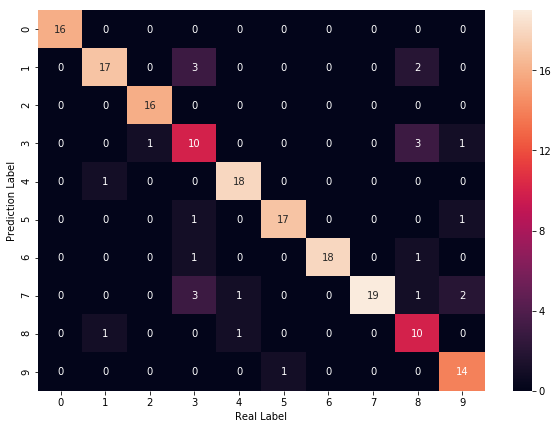

In [5]:
import seaborn as sn

df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='.20g', annot=True)
plt.xlabel('Real Label')
plt.ylabel('Prediction Label')
plt.show()